In [6]:
import os
import re
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from scipy.stats import gaussian_kde, loguniform, gamma
from math import lgamma
from tqdm import tqdm
from ast import literal_eval
from glob import glob
from tqdm import tqdm
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
from astropy.table import Table, join
import astropy.coordinates as coord
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from astropy.io import fits

# these packages are for fitting with numpyro
import numpyro
from numpyro import distributions as dist, infer
import numpyro_ext
import arviz as az
import jax

# these are psps imports
from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.simulate_transit as simulate_transit
import psps.utils as utils

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

import warnings
warnings.filterwarnings("ignore")

path = '/Users/chrislam/Desktop/psps/' 

# we're gonna need this for reading in the initial Berger+ 2020 data
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        pass


%matplotlib inline
path = '/Users/chrislam/Desktop/psps/data/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age  \
0          -86.6     3.373          0.067         -0.081  ...     2.47   
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1  \
0         

In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)


In [3]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [4]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


### Right off the bat, we need to draw parameters for which we have uncertainties. The very selection of stars for our samples depends on it. Not to be dramatic.

In [5]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(5300, 7500, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000)
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3.6, 4.7, 100)

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.normal(mode, err1), 2)

        # asymmetric uncertainties
        elif err1!=err2:
            pdf = simulate_helpers.make_pdf_rows(x, mode, err1, err2)
            pdf = pdf/np.sum(pdf)

            try:
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.around(np.random.choice(x, p=pdf), 2)
            except Exception as e:
                print("EXCEPTION: ", i, pdf, mode, err1, err2)
                print(e)
                break
                continue
        #"""

        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    df = uniques.merge(df, how='right')
    df[drawn] = df[drawn].fillna(method='ffill')
    
    return df

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df


In [ ]:
kepler_stars_bootstrapped = pd.DataFrame()

for i in tqdm(range(10)):
	kepler_stars_temp = draw_asymmetrically(kepler_stars, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	kepler_stars_bootstrapped = pd.concat([kepler_stars_bootstrapped, kepler_stars_temp])

In [49]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(fgk))

147900


In [50]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh  \
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN   
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [51]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

catalog['logR'] = np.log10(catalog.iso_rad)


      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag  \
0          -86.6     3.373          0.067         -0.081  ...   9.559   
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE  \
0     0.017    1.5239        

In [52]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog_dwarfs = catalog.loc[catalog['is_giant'] == False]
print(len(catalog_dwarfs))
print(catalog_dwarfs.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax  \
2         -139.9     3.834          0.033         -0.032  ...    1.2137   
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

[   4   14   67  171  326 1291 2286 2784 2988 3224 3602 3854 4330 4751
 5341 5709 6190 6307 6247 5974 5561 5089 4729 4196 3825 3176 2771 2578
 2221 1912 1545 1344 1197 1067  881  743  693  543  425  448  364  288
  262  212  215  166  161  127  105   93] [4879.6   4932.002 4984.404 5036.806 5089.208 5141.61  5194.012 5246.414
 5298.816 5351.218 5403.62  5456.022 5508.424 5560.826 5613.228 5665.63
 5718.032 5770.434 5822.836 5875.238 5927.64  5980.042 6032.444 6084.846
 6137.248 6189.65  6242.052 6294.454 6346.856 6399.258 6451.66  6504.062
 6556.464 6608.866 6661.268 6713.67  6766.072 6818.474 6870.876 6923.278
 6975.68  7028.082 7080.484 7132.886 7185.288 7237.69  7290.092 7342.494
 7394.896 7447.298 7499.7  ]


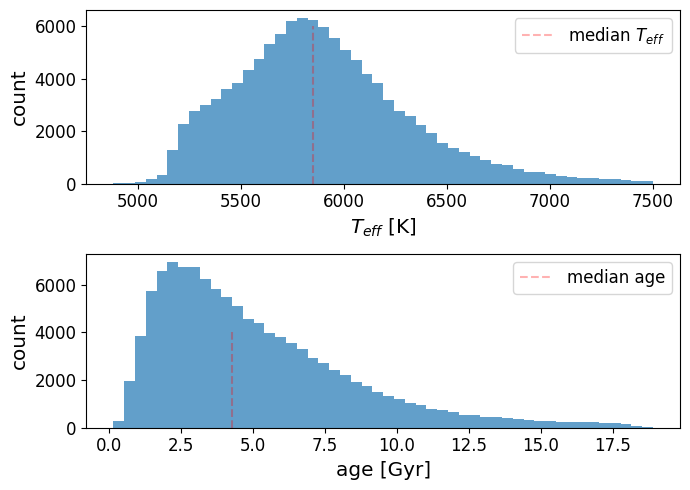

In [17]:
#plt.scatter(catalog.iso_teff, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=2)
#plt.ylabel('total age error [Gyrs]')
#plt.xlabel('$T_{eff}$ [K]')
#plt.show()

# teff histogram for all stars with well-constrained ages 
teff_hist, teff_bin_edges = np.histogram(catalog.iso_teff, bins=50)
print(teff_hist, teff_bin_edges)
#plt.bar(teff_bin_edges[:-1], teff_hist, width = 0.3)

#fig, axes = plt.subplots(figsize=(5,5))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))

#ax1 = plt.subplot2grid((2,1), (0,0))
ax1.hist(catalog.iso_teff, bins=50, alpha=0.7)
#ax1.hist(catalog.loc[catalog['iso_age'] <= 8].iso_teff, bins=50, alpha=0.7)
ax1.set_ylabel("count")
ax1.set_xlabel(r"$T_{eff}$ [K]")
# plot vertical red line through median Teff
ax1.plot([np.median(catalog.iso_teff), np.median(catalog.iso_teff)], 
         [0,6000], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
ax1.legend()

#ax2 = plt.subplot2grid((2,1), (1,0))
ax2.hist(catalog.iso_age, bins=50, alpha=0.7)
#ax2.hist(catalog.loc[catalog['iso_age'] <= 8].iso_age, bins=50, alpha=0.7)
# plot vertical red line through median age 
ax2.plot([np.median(catalog.iso_age), np.median(catalog.iso_age)], 
         [0,4000], color='r', alpha=0.3, linestyle='--', label='median age')
#ax2.set_xlim([0, 8])
ax2.set_ylabel("count")
ax2.set_xlabel("age [Gyr]")
ax2.legend()
fig.tight_layout()
plt.savefig('/Users/chrislam/Desktop/psps/plots/sample_properties_og_pre_age_cut.pdf', format='pdf')

plt.show()

In [54]:
print(np.nanmedian(catalog_dwarfs.iso_age_err1/catalog_dwarfs.iso_age))
print(np.nanmedian(catalog_dwarfs.iso_age_err2/catalog_dwarfs.iso_age))

0.4622425629290618
-0.376940133037694


/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_5658/1016877822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_dwarfs['fractional_err1'] = catalog_dwarfs.iso_age_err1/catalog_dwarfs.iso_age
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_5658/1016877822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_dwarfs['fractional_err2'] = catalog_dwarfs.iso_age_err2/catalog_dwarfs.iso_age


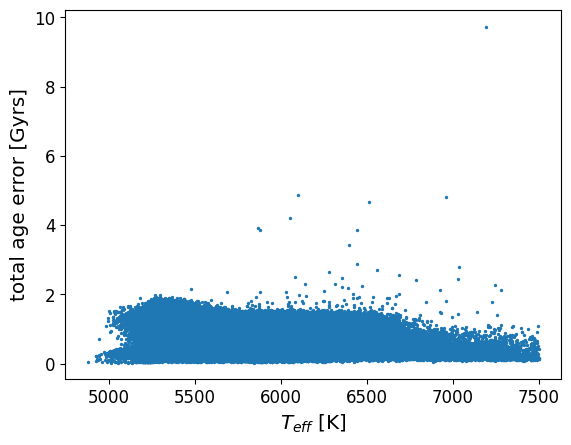

total:  51551


In [55]:
# get rid of stars with fractional age errors greater than median age error [+0.51, -0.40]

catalog_dwarfs['fractional_err1'] = catalog_dwarfs.iso_age_err1/catalog_dwarfs.iso_age
catalog_dwarfs['fractional_err2'] = catalog_dwarfs.iso_age_err2/catalog_dwarfs.iso_age
plt.scatter(catalog_dwarfs.iso_teff, catalog_dwarfs.fractional_err1, s=2)
plt.ylabel('total age error [Gyrs]')
plt.xlabel('$T_{eff}$ [K]')
plt.show()

catalog_dwarfs_age = catalog_dwarfs.loc[catalog_dwarfs.fractional_err1 <= 0.46]
catalog_dwarfs_age = catalog_dwarfs_age.loc[np.abs(catalog_dwarfs_age.fractional_err2) <= 0.38]
print("total: ", len(catalog_dwarfs_age))
#print("K dwarfs: ", len(catalog.loc[catalog.iso_teff < 5300])) # how many of these are K dwarfs?
#print("percentage of K dwarfs in sample: ", len(catalog.loc[catalog.iso_teff < 5300])/len(catalog))

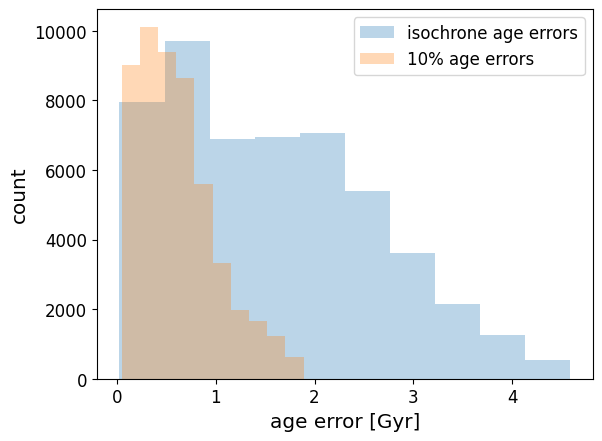

In [56]:
plt.hist(0.5*(catalog_dwarfs_age.iso_age_err1-catalog_dwarfs_age.iso_age_err2), alpha=0.3, label='isochrone age errors')
plt.hist(0.1*catalog_dwarfs_age.iso_age, alpha=0.3, label='10% age errors')
plt.legend()
plt.ylabel('count')
plt.xlabel('age error [Gyr]')
plt.show()

In [71]:
# young vs old fraction
print("stars younger than 1 Gyr: ", len(catalog_dwarfs_age.loc[catalog_dwarfs_age.iso_age <= 1]))
print("stars older than 1 Gyr: ", len(catalog_dwarfs_age.loc[catalog_dwarfs_age.iso_age > 1]))
print("percentage of sample younger than 1 Gyr: ", len(catalog_dwarfs_age.loc[catalog_dwarfs_age.iso_age <= 1])/len(catalog_dwarfs_age))
print("median age of sample: ", np.median(catalog_dwarfs_age.iso_age))

stars younger than 1 Gyr:  415
stars older than 1 Gyr:  51136
percentage of sample younger than 1 Gyr:  0.008050280304940738
median age of sample:  5.47


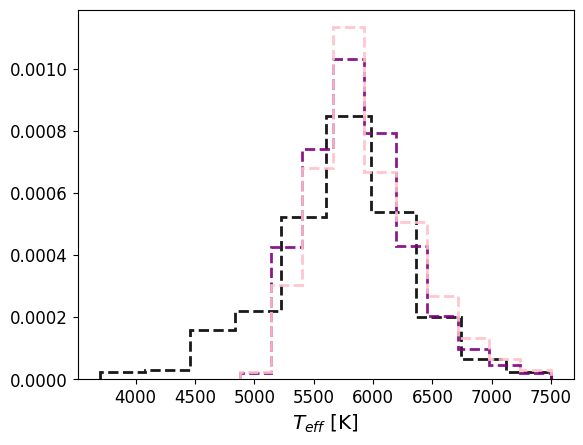

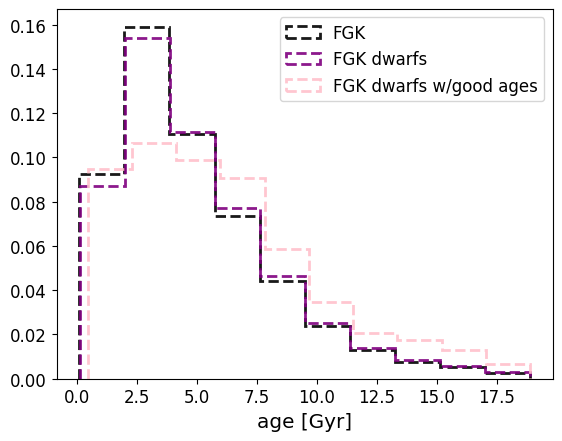

In [76]:
### compare Teff and age for the last three cuts
plt.hist(catalog.iso_teff, density=True, linestyle='--', linewidth=2, histtype='step', color='k', alpha=0.9, label='FGK')
plt.hist(catalog_dwarfs.iso_teff, density=True, linestyle='--', linewidth=2, histtype='step', color='purple', alpha=0.9, label='FGK dwarfs')
plt.hist(catalog_dwarfs_age.iso_teff, density=True, linestyle='--', linewidth=2, histtype='step', color='pink', alpha=0.9, label='FGK dwarfs w/good ages')
plt.xlabel(r"$T_{eff}$ [K]")
plt.savefig('/Users/chrislam/Desktop/psps/plots/k2/stellar_cuts_teff_kepler.png')
plt.show()

plt.hist(catalog.iso_age, density=True, linestyle='--', linewidth=2, histtype='step', color='k', alpha=0.9, label='FGK')
plt.hist(catalog_dwarfs.iso_age, density=True, linestyle='--', linewidth=2, histtype='step', color='purple', alpha=0.9, label='FGK dwarfs')
plt.hist(catalog_dwarfs_age.iso_age, density=True, linestyle='--', linewidth=2, histtype='step', color='pink', alpha=0.9, label='FGK dwarfs w/good ages')
plt.xlabel("age [Gyr]")
plt.legend()
plt.savefig('/Users/chrislam/Desktop/psps/plots/k2/stellar_cuts_age_kepler.png')
plt.show()

In [58]:
catalog_dwarfs_age.to_csv('/Users/chrislam/Desktop/psps/data/berger_kepler_stellar_fgk_post_referee.csv', index=False)
#catalog.loc[catalog['iso_age'] <= 8]

[   4   13   47  105  147  292  651  971 1066 1132 1320 1535 1746 2075
 2527 2831 3109 3266 3157 2948 2699 2022 1528 1312 1474 1511 1464 1477
 1276 1131  913  805  724  632  556  465  438  351  243  293  223  190
  181  129  146  101  109   85   74   57] [4879.6   4932.002 4984.404 5036.806 5089.208 5141.61  5194.012 5246.414
 5298.816 5351.218 5403.62  5456.022 5508.424 5560.826 5613.228 5665.63
 5718.032 5770.434 5822.836 5875.238 5927.64  5980.042 6032.444 6084.846
 6137.248 6189.65  6242.052 6294.454 6346.856 6399.258 6451.66  6504.062
 6556.464 6608.866 6661.268 6713.67  6766.072 6818.474 6870.876 6923.278
 6975.68  7028.082 7080.484 7132.886 7185.288 7237.69  7290.092 7342.494
 7394.896 7447.298 7499.7  ]


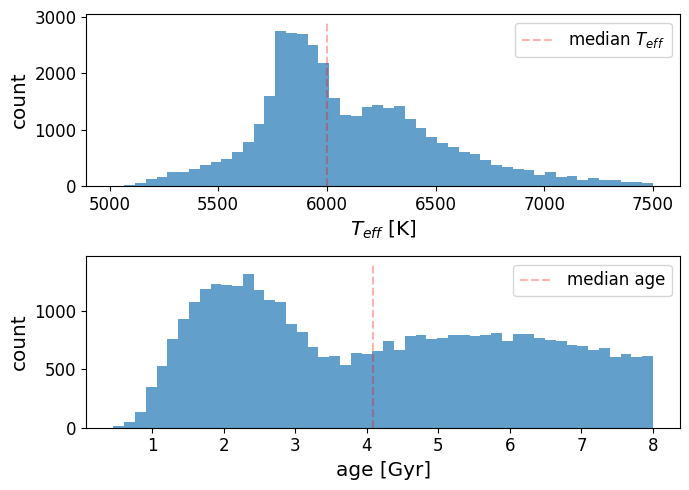

In [25]:
# teff histogram for all stars with well-constrained ages 
teff_hist, teff_bin_edges = np.histogram(catalog.iso_teff, bins=50)
print(teff_hist, teff_bin_edges)
#plt.bar(teff_bin_edges[:-1], teff_hist, width = 0.3)

#fig, axes = plt.subplots(figsize=(5,5))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))

#ax1 = plt.subplot2grid((2,1), (0,0))
#ax1.hist(catalog.iso_teff, bins=50, alpha=0.7)
ax1.hist(catalog.loc[catalog['iso_age'] <= 8].iso_teff, bins=50, alpha=0.7)
ax1.set_ylabel("count")
ax1.set_xlabel(r"$T_{eff}$ [K]")
# plot vertical red line through median Teff
ax1.plot([np.median(catalog.loc[catalog['iso_age'] <= 8].iso_teff), np.median(catalog.loc[catalog['iso_age'] <= 8].iso_teff)], 
         [0,2900], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
ax1.legend()

#ax2 = plt.subplot2grid((2,1), (1,0))
#ax2.hist(catalog.iso_age, bins=50, alpha=0.7)
ax2.hist(catalog.loc[catalog['iso_age'] <= 8].iso_age, bins=50, alpha=0.7)
# plot vertical red line through median age 
ax2.plot([np.median(catalog.loc[catalog['iso_age'] <= 8].iso_age), np.median(catalog.loc[catalog['iso_age'] <= 8].iso_age)], 
         [0,1400], color='r', alpha=0.3, linestyle='--', label='median age')
ax2.set_ylabel("count")
ax2.set_xlabel("age [Gyr]")
ax2.legend()
fig.tight_layout()
plt.savefig('/Users/chrislam/Desktop/psps/plots/k2/sample_properties_post_age_cut.pdf', format='pdf')

plt.show()

Are asymmetric errors close enough to being treatable as Gaussian-distributed?

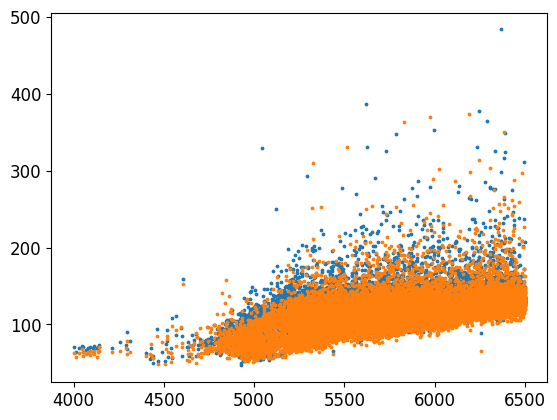

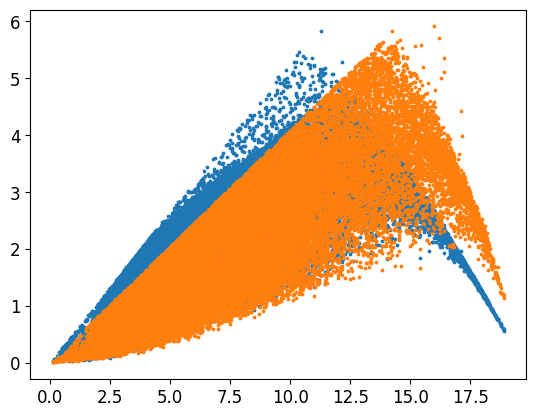

In [23]:
plt.scatter(catalog.iso_teff, catalog.iso_teff_err1, s=3)
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_teff_err2), s=3)
plt.show()

plt.scatter(catalog.iso_age, catalog.iso_age_err1, s=3)
plt.scatter(catalog.iso_age, np.abs(catalog.iso_age_err2), s=3)
plt.show()

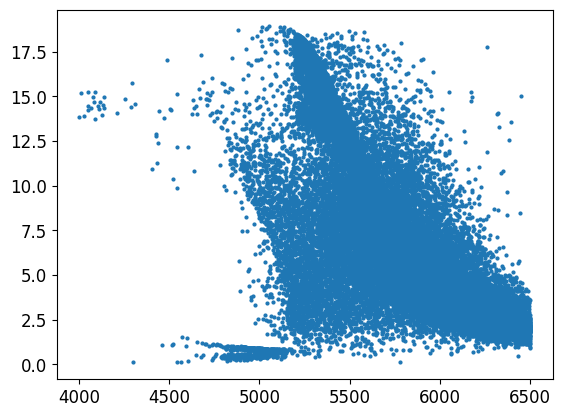

In [24]:
plt.scatter(catalog.iso_teff, catalog.iso_age, s=4)
plt.show()

I think we can get away with averaging the asymmetric errors and drawing them from a normal distribution.

EDIT: Actually, this is not a safe assumption. See Asymmetric Errors subsection below.

In [17]:
catalog.iso_teff_err = 0.5 * (catalog.iso_teff_err1 + np.abs(catalog.iso_teff_err2))
catalog.iso_age_err = 0.5 * (catalog.iso_age_err1 + np.abs(catalog.iso_age_err2))

/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_82311/908293507.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  catalog.iso_teff_err = 0.5 * (catalog.iso_teff_err1 + np.abs(catalog.iso_teff_err2))
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_82311/908293507.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  catalog.iso_age_err = 0.5 * (catalog.iso_age_err1 + np.abs(catalog.iso_age_err2))


Split sample into F, G, and K dwarfs, as well as young, middle-aged, and old stars.

In [25]:
fdwarfs = catalog.loc[(catalog.iso_teff < 7500) & (catalog.iso_teff > 6000)]
gdwarfs = catalog.loc[(catalog.iso_teff < 6000) & (catalog.iso_teff > 5300)]
kdwarfs = catalog.loc[(catalog.iso_teff < 5300) & (catalog.iso_teff > 3700)]
print(len(fdwarfs), len(gdwarfs), len(kdwarfs))

young = catalog.loc[(catalog.iso_age < 3) & (catalog.iso_age > 0)]
middle = catalog.loc[(catalog.iso_age < 6) & (catalog.iso_age > 3)]
old = catalog.loc[(catalog.iso_age < 9) & (catalog.iso_age > 6)]
ancient = catalog.loc[(catalog.iso_age > 9)]

print(len(young), len(middle), len(old), len(ancient))

17479 33252 4074
9975 19751 13445 11489


### Time to crossmatch

In [15]:
# source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative
path = '/Users/chrislam/Desktop/psps/data/'
kois = pd.read_csv(path+'cumulative_2021.03.04_20.04.43.csv')
kois = kois.loc[kois.koi_disposition != 'FALSE POSITIVE']
#kois_score = kois.loc[kois.koi_score >= 0.5]
#print(kois)
#print(list(kois.columns))
print("KOI disposition: ", len(kois.kepid.unique()), len(kois.kepid))


KOI disposition:  3611 4724


In [16]:
positives_kepler = pd.merge(kois, catalog, how='inner', left_on='kepid', right_on='KIC') 


In [17]:
path = '/Users/chrislam/Desktop/psps/data/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580   
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5  \
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0   
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0  \
0          0.0          0.0          0.

In [18]:
kepler_stellar_enriched = pd.merge(kepler_stellar, catalog, how='inner', left_on='kepid', right_on='KIC')
print("number of stars in sample: ", len(kepler_stellar_enriched))


number of stars in sample:  59580


In [19]:
kepler_planet_enriched = pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')
print("number of planet-hosting systems in sample, koi_disposition: ", len(kepler_planet_enriched), len(kepler_planet_enriched.kepid.unique()))



number of planet-hosting systems in sample, koi_disposition:  1094 871


In [20]:
# output enriched Berger cross-matches
kepler_stellar_enriched.to_csv('/Users/chrislam/Desktop/psps/data/berger_kepler_stellar_fgk_og.csv', index=False)
# output planet multiplicity
#kepler_planet_enriched.to_csv('/Users/chris/Desktop/mastrangelo/data/pnum_plus_cands_fgk.csv', index=False)

In [55]:
print("observed Kepler transit multiplicity, koi_disposition")
tm_disposition = kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()
print(tm_disposition)
print(len(catalog)-833-134-38-15-5)
print(len(catalog)-tm_disposition.sum())

print("observed Kepler transit multiplicity, koi_score")
tm_score = kepler_planet_enriched_score.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()
print(tm_score)
print(len(catalog)-tm_score.sum())

print("observed Kepler transit multiplicity, koi_fpp")
tm_fpp = kepler_planet_enriched_fpp.groupby('kepid').count().tm_designation.reset_index().groupby('tm_designation').count()
print(tm_fpp)
print(len(catalog)-tm_fpp.sum())


observed Kepler transit multiplicity, koi_disposition
           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5
66355
kepid    66355
dtype: int64
observed Kepler transit multiplicity, koi_score
           kepid
koi_count       
1            631
2            115
3             32
4             10
5              4
kepid    66588
dtype: int64
observed Kepler transit multiplicity, koi_fpp
                kepid
tm_designation       
1                1088
2                 115
3                  34
4                   9
5                   3
kepid    66131
dtype: int64


(array([2.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 5.000e+00, 9.000e+00,
        9.000e+00, 1.100e+01, 1.600e+01, 4.200e+01, 1.290e+02, 3.840e+02,
        1.034e+03, 2.142e+03, 4.055e+03, 6.406e+03, 5.789e+03, 2.700e+03,
        9.030e+02, 9.000e+01]),
 array([-2.371  , -2.22315, -2.0753 , -1.92745, -1.7796 , -1.63175,
        -1.4839 , -1.33605, -1.1882 , -1.04035, -0.8925 , -0.74465,
        -0.5968 , -0.44895, -0.3011 , -0.15325, -0.0054 ,  0.14245,
         0.2903 ,  0.43815,  0.586  ]),
 <BarContainer object of 20 artists>)

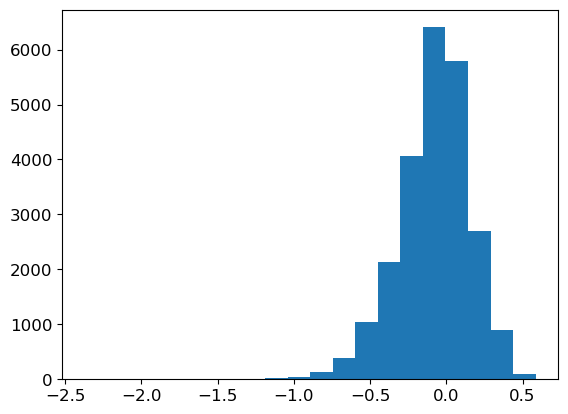

In [35]:
plt.hist(catalog.feh, bins=20)

Both Gaia and the planet-host catalog bring metallicity to the table. But I trust metallicities from CKS more because it's a better instrument and definitionally complete for our planet-host sample.

In [27]:
print(kepler_stellar_enriched.feh_x)
print(kepler_stellar_enriched.feh_y)


0       -0.24
1       -0.06
2       -0.26
3       -0.26
4       -0.24
         ... 
67375   -0.06
67376    0.12
67377   -0.26
67378   -0.28
67379   -0.16
Name: feh_x, Length: 67380, dtype: float64
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
67375    0.012
67376      NaN
67377    0.038
67378   -0.050
67379    0.056
Name: feh_y, Length: 67380, dtype: float64


In [37]:
kepler_planet_enriched.groupby('kepid').count().reset_index().groupby('koi_count').count().kepid

koi_count
1    833
2    134
3     38
4     15
5      5
Name: kepid, dtype: int64